## Análise de Resultados - Live Trading Portfolio

### Considerações iniciais

Nesta análise exploratória, iremos avaliar os dados de performance mais relevantes para um portfólio de algoritmos que desenvolvi, o qual operou em Live Trading pelo período de um ano em uma conta de controle. <br>

Exploraremos as principais métricas relacionadas a avaliação de performance, comparando o portfólio com um benchmark de referência.<br>

Investimento inicial alocado para o estudo: `$ 50.000,00`<br>


#### Importando bibliotecas e carregando arquivo do relatório de performance

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyfolio as pf
import yfinance as yf
from scipy.stats import linregress
from bcb import sgs
import warnings

inicio = '2023-08-26'
fim = '2024-08-26'
initial_deposit = 50000

# Carregar arquivo importado do mt5
file_path = 'https://raw.githubusercontent.com/davimmoraes/live_trading_portfolio_analysis/master/ReportHistory-201061_1year.xlsx'
df = pd.read_excel(file_path, skiprows=6)
warnings.simplefilter("ignore", UserWarning)

#### Filtrando o relatório e organizando dataframe

In [130]:
orders_index = df[df.apply(lambda row: row.astype(str).str.contains('Orders', case=False).any(), axis=1)].index

if not orders_index.empty:
    orders_index = orders_index[0]
    df = df.iloc[:orders_index]
    df.reset_index(drop=True, inplace=True)    

    if 'Profit' in df.columns:        
        df['Profit'] = pd.to_numeric(df['Profit'], errors='coerce')    
        df = df.dropna(subset=['Profit'])
    else:
        print("A coluna 'Profit' não foi encontrada.")
else:
    print("A palavra 'Orders' não foi encontrada no DataFrame.")

df['Portfolio PnL'] = df['Profit'].cumsum()
df['Portfolio Equity'] = initial_deposit + df['Profit'].cumsum()
df['Time'] = pd.to_datetime(df['Time'])
df['Data'] = df['Time']
df['Data'] = pd.to_datetime(df['Data'])
df = df[(df['Data'] >= pd.to_datetime(inicio)) & (df['Data'] <= pd.to_datetime(fim))]
df['Data'] = df['Time'].dt.date


Com o dataframe pronto, calculamos o lucro total do porfolio e plotamos a sua curva de capital.<br>

Vamos criar também um novo dataframe para armazenar as métricas de performance que serão calculadas, começamos armenando o lucro total do sistema e seu CAGR (crescimento anual composto).

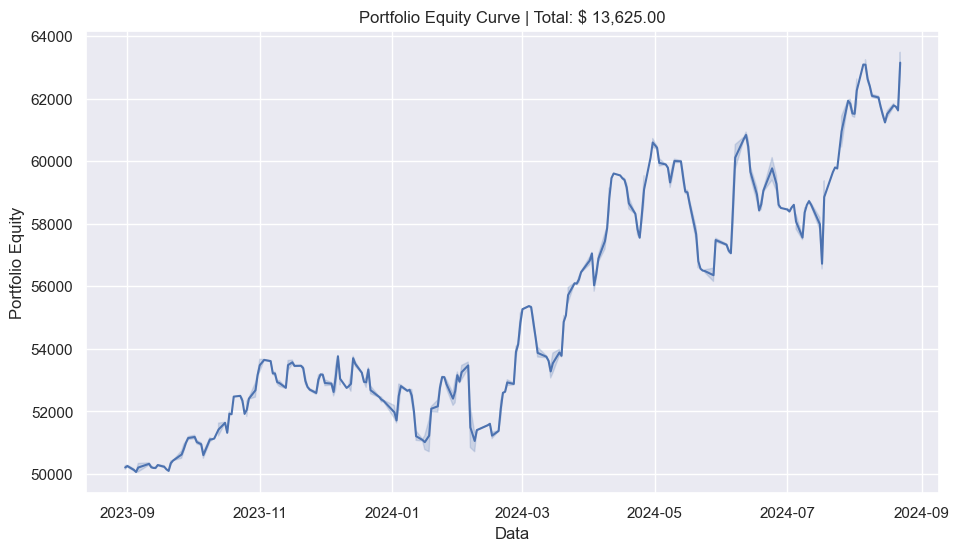

,Métrica,Portfolio
0,Deposit,$ 50000.00
1,Lucro,$ 13625.00
2,CAGR,27.96%


In [131]:
# Lucro portfolio
portfolio_profit = df['Profit'].sum()

# Valor final
valor_final_portfolio = initial_deposit + df['Portfolio PnL'].iloc[-1]

# CAGR
valor_final_portfolio = initial_deposit + df['Portfolio PnL'].iloc[-1]
num_anos = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr = (valor_final_portfolio/ initial_deposit) ** (1 / num_anos) - 1
cagr *= 100

# Criar dataframe para métricas
df_metricas = pd.DataFrame({'Métrica': ['Deposit','Lucro','CAGR'],'Portfolio': [f'$ {initial_deposit:.2f}',f"$ {df['Portfolio PnL'].iloc[-1]:.2f}",f"{cagr:.2f}%"]
})

plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Data', y='Portfolio Equity')
plt.title(f'Portfolio Equity Curve | Total: {f"$ {portfolio_profit:,.2f}"}')
plt.show()
df_metricas

- CAGR: Taxa de crescimento anual composta ao longo do período analisado.<br>

#### Calculando drawdowns - rebaixamento da curva de capital

In [132]:
# Calcular pico de drawdown
df['Max_Peak'] = df['Portfolio Equity'].cummax()

# Calcular o drawdown
df['Drawdown'] = df['Portfolio Equity'] - df['Max_Peak']
df['Drawdown Percent'] = df['Drawdown']*100 / df['Max_Peak']
max_drawdown_financeiro_portfolio = df['Drawdown'].min()
data_max_drawdown_portfolio = df[df['Drawdown'] == max_drawdown_financeiro_portfolio]['Data'].values[0]
max_peak_at_drawdown_portfolio = df[df['Data'] == data_max_drawdown_portfolio]['Max_Peak'].values[0]
max_drawdown_percent_portfolio = (max_drawdown_financeiro_portfolio / max_peak_at_drawdown_portfolio) * 100

# Adicionar ao dataframe de métricas
df_metricas__portfolio_drawdown = pd.DataFrame({
    'Métrica': ['Drawdown Max ($)', 
                'Drawdown Max (%)'],
    'Portfolio': [f"$ {max_drawdown_financeiro_portfolio:.2f}", 
              f"{max_drawdown_percent_portfolio:.2f}%"]
})

df_metricas = pd.concat([df_metricas,df_metricas__portfolio_drawdown], ignore_index=True)

# Calcular retornos
df['Returns'] = np.log(df['Portfolio Equity'] / df['Portfolio Equity'].shift(1)).fillna(0)

df_metricas

,Métrica,Portfolio
0,Deposit,$ 50000.00
1,Lucro,$ 13625.00
2,CAGR,27.96%
3,Drawdown Max ($),$ -5038.00
4,Drawdown Max (%),-8.28%


- Drawdown max: máxima redução de capital em relação ao seu pico anterior.<br>

#### Distribuição e densidade do drawdown

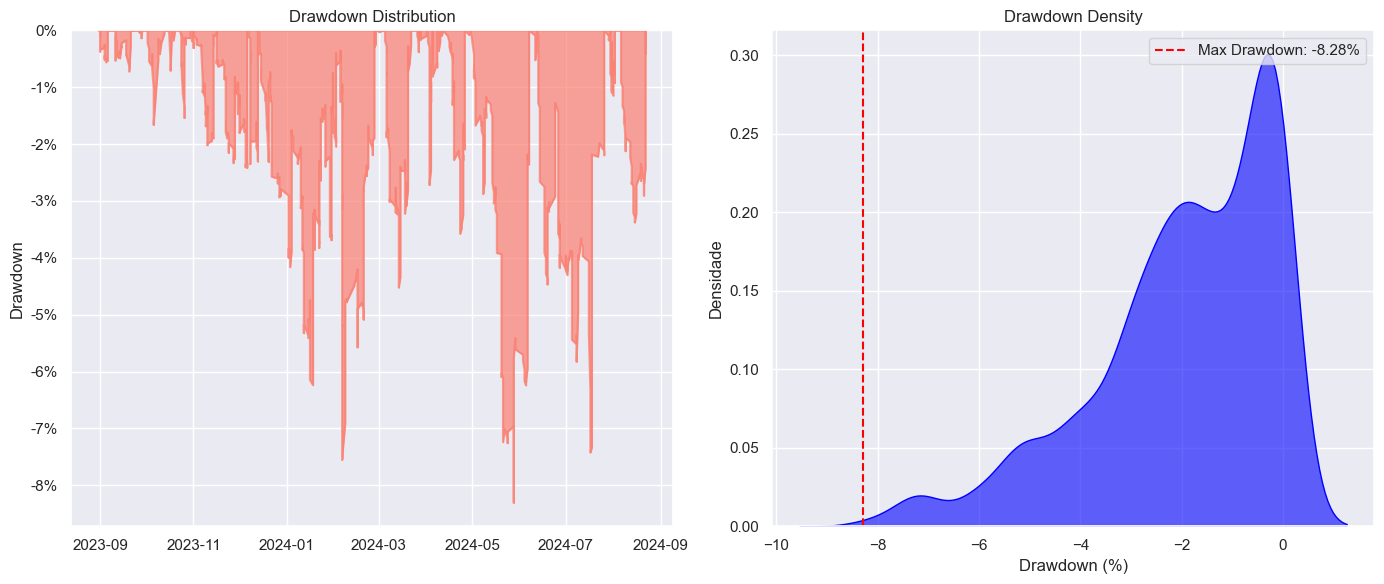

In [133]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plotar gráfico distribuição drawdown
df['DataIndex'] = df['Data']
df.set_index('DataIndex', inplace=True)
pf.plot_drawdown_underwater(df['Returns'], ax=axes[0])
axes[0].set_title(f'Drawdown Distribution')


# Plotar o gráfico de densidade no segundo gráfico
sns.kdeplot(df['Drawdown Percent'], fill=True, color='blue', alpha=0.6, ax=axes[1])
max_drawdown_point = df['Drawdown Percent'].min() 
axes[1].axvline(max_drawdown_point, color='red', linestyle='--', label=f'Max Drawdown: {max_drawdown_point:.2f}%')
axes[1].legend(loc='best')
axes[1].set_xlabel('Drawdown (%)')
axes[1].set_ylabel('Densidade')
axes[1].set_title('Drawdown Density')

plt.tight_layout()
plt.show()

In [134]:
# Mostrar valores
print(f"Max drawdown on deposit = {max_drawdown_financeiro_portfolio/initial_deposit*100:.2f}%")
print(f"Drawdown mean = {df['Drawdown Percent'].mean():.2f}%")
print(f"Drawdown median = {df['Drawdown Percent'].median():.2f}%")


Max drawdown on deposit = -10.08%
Drawdown mean = -1.96%
Drawdown median = -1.65%


Observamos um drawdown máximo de -R\$5.038, o que representa um drawdown de 8.28% no momento em que o mesmo aconteceu, e um drawdown máximo de 10,07% sobre o valor de depósito.<br>
A média e mediana dos drawdowns estão entre 1.6% e 2.0%.

#### Calculando a volatilidade do portfolio

In [136]:
# Calcular os retornos diários
retornos_diarios_portfolio = (initial_deposit + df['Portfolio PnL']).pct_change().dropna()

# Calcular a volatilidade
volatilidade_diaria_portfolio = retornos_diarios_portfolio.std() * 100
dias_de_negociacao_por_ano = 252
volatilidade_anualizada_portfolio = volatilidade_diaria_portfolio * np.sqrt(dias_de_negociacao_por_ano)

# Adicionar ao dataframe de métricas
df_metricas_portfolio_vol = pd.DataFrame({
    'Métrica': ['Volatilidade Diária', 'Volatilidade Anual'],
    'Portfolio': [f"{volatilidade_diaria_portfolio:.2f}%", f"{volatilidade_anualizada_portfolio:.2f}%"]
})

df_metricas = pd.concat([df_metricas, df_metricas_portfolio_vol], ignore_index=True)

df_metricas

,Métrica,Portfolio
0,Deposit,$ 50000.00
1,Lucro,$ 13625.00
2,CAGR,27.96%
3,Drawdown Max ($),$ -5038.00
4,Drawdown Max (%),-8.28%
5,Volatilidade Diária,0.29%
6,Volatilidade Anual,4.67%


- Volatilidade Diária: Medida da variabilidade dos retornos diários do portfólio.<br>
- Volatilidade Anualizada: Volatilidade diária ajustada para uma base anual, refletindo o risco do portfólio ao longo do ano.<br>

#### Obtendo dados do benchmark - Ibovespa<br>

In [137]:
# Coletar dados
symbol = '^BVSP'
df_benchmark = yf.download(symbol, start=inicio, end=fim)
close_prices_benchmark = df_benchmark['Close']

[*********************100%***********************]  1 of 1 completed


##### Calculando retornos, drawdown máximo e volatilidade do benchmark e adicionando ao dataframe

Text(0.5, 1.0, 'Ibovespa')

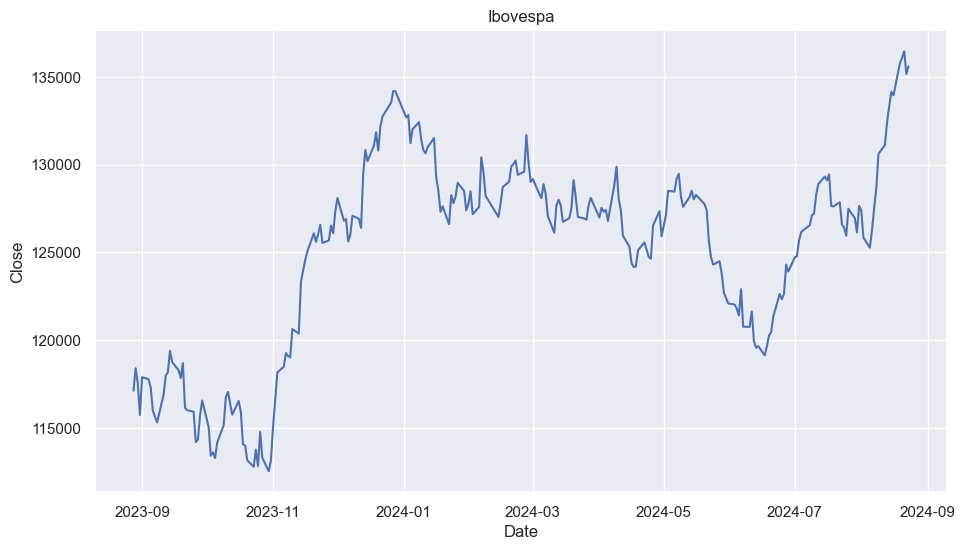

In [138]:
# Normalizar o preço de fechamento para refletir o depósito inicial
close_prices_normalized_benchmark = (close_prices_benchmark / close_prices_benchmark.iloc[0]) * initial_deposit

# Calcular o retorno absoluto total
preco_inicial_benchmark = close_prices_normalized_benchmark.iloc[0]
preco_final_benchmark = close_prices_normalized_benchmark.iloc[-1]
retorno_absoluto_total_benchmark = (preco_final_benchmark - preco_inicial_benchmark) / preco_inicial_benchmark

# Calcular os retornos diários
retornos_diarios_benchmark = close_prices_normalized_benchmark.pct_change().dropna()

# Calcular o drawdown máximo
acumulado_benchmark= close_prices_normalized_benchmark.cummax()
drawdown_benchmark= (close_prices_normalized_benchmark - acumulado_benchmark) / acumulado_benchmark

# Encontrar a data do drawdown máximo
data_max_drawdown_benchmark = drawdown_benchmark.idxmin()

# Obter o valor do acumulado máximo na data do maior drawdown
max_peak_at_drawdown_benchmark = acumulado_benchmark.loc[data_max_drawdown_benchmark]

# Obter valor financeiro do drawdown máximo
drawdown_maximo_financeiro_benchmark = (drawdown_benchmark.loc[data_max_drawdown_benchmark]) * initial_deposit

# Calcular o drawdown máximo percentual
drawdown_maximo_percentual_benchmark = (drawdown_maximo_financeiro_benchmark / max_peak_at_drawdown_benchmark) * 100

# Calcular os retornos diários do benchmark
retornos_diarios_benchmark = close_prices_normalized_benchmark.pct_change().dropna()

# Calcular a volatilidade
volatilidade_diaria_benchmark = retornos_diarios_benchmark.std() * 100

# Calcular a volatilidade anualizada
dias_de_negociacao_por_ano = 252
volatilidade_anualizada_benchmark = volatilidade_diaria_benchmark * np.sqrt(dias_de_negociacao_por_ano)

# Calcular lucro do buy and hold teórico no benchmark
lucro_benchmark = retorno_absoluto_total_benchmark*initial_deposit
valor_final_benchmark = initial_deposit + lucro_benchmark
num_anos = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr_benchmark= (valor_final_benchmark / initial_deposit) ** (1 / num_anos) - 1
cagr_benchmark *= 100

# Adicionar nova coluna ao dataframe de métricas para o benchmark 
df_metricas['Benchmark'] = [
    f'$ {initial_deposit:.2f}', 
    f'$ {lucro_benchmark:.2f}', 
    f'{cagr_benchmark:.2f}%', 
    f"$ {drawdown_maximo_financeiro_benchmark:.2f}",
    f"{drawdown_maximo_percentual_benchmark:.2f}%",
    f"{volatilidade_diaria_benchmark:.2f}%", 
    f"{volatilidade_anualizada_benchmark:.2f}%", 
]

plt.figure(figsize=(11, 6))
sns.lineplot(close_prices_benchmark)
plt.title('Ibovespa')

In [139]:
df_metricas

,Métrica,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Lucro,$ 13625.00,$ 7892.27
2,CAGR,27.96%,16.18%
3,Drawdown Max ($),$ -5038.00,$ -5609.79
4,Drawdown Max (%),-8.28%,-9.79%
5,Volatilidade Diária,0.29%,0.83%
6,Volatilidade Anual,4.67%,13.13%


In [140]:
# Printar drawdown financeiro máximo sobre o depósito
print(drawdown_maximo_financeiro_benchmark/initial_deposit*100)

-11.219577626421453


Foi considerada uma alocação financeira do valor total do depósito inicial no benchmark, para fins de comparação*.<br>

Observamos um drawdown financeiro máximo de -R\$5.609.79, o que representa um drawdown de 9.79% no momento em que o mesmo aconteceu, e um drawdown máximo de 11,21% sobre o valor de depósito.

Observamos que durante o período analisado o benchmark se valorizou em 16.18%, um valor considerável considerando ser o índice de um mercado emergente e a janela de observação de 1 ano.<br>

###### *Ibovespa é uma carteira teórica, porém a operação poderia ser realizada facilmente através de um ETF que acompanha o índice, por exemplo.

#### Calculando a regressão linear do portfolio

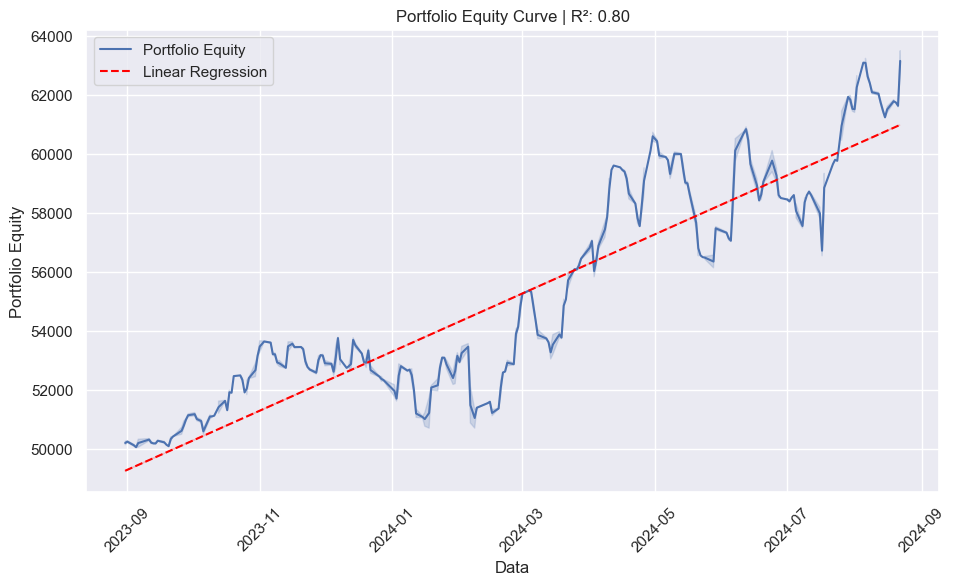

In [141]:
# Converter a coluna de datas em números para a regressão
df['Time_ordinal'] = df['Time'].map(pd.Timestamp.toordinal)

# Calcular a regressão linear
slope, intercept, r_value, p_value, std_err = linregress(df['Time_ordinal'], df['Portfolio Equity'])

# Calcular o R²
r_squared = r_value**2

# Adicionar a linha de regressão ao DataFrame
df['Regressao'] = intercept + slope * df['Time_ordinal']

# Adicionar R² ao nosso dataframe de métricas
df_metricas_portfolio_lr = pd.DataFrame({'Métrica':['Curve Smoothness - R²'],'Portfolio':[f'{r_squared:.2f}']})
df_metricas = pd.concat([df_metricas, df_metricas_portfolio_lr], ignore_index=True)



plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Data', y='Portfolio Equity', label='Portfolio Equity')
sns.lineplot(data=df, x='Data', y='Regressao', color='red', linestyle='--', label='Linear Regression')

plt.title(f'Portfolio Equity Curve | R²: {r_squared:.2f}')
plt.xlabel('Data')
plt.ylabel('Portfolio Equity')
plt.xticks(rotation=45)
plt.legend()
plt.show()

##### Calculando regressão linear do benchmark

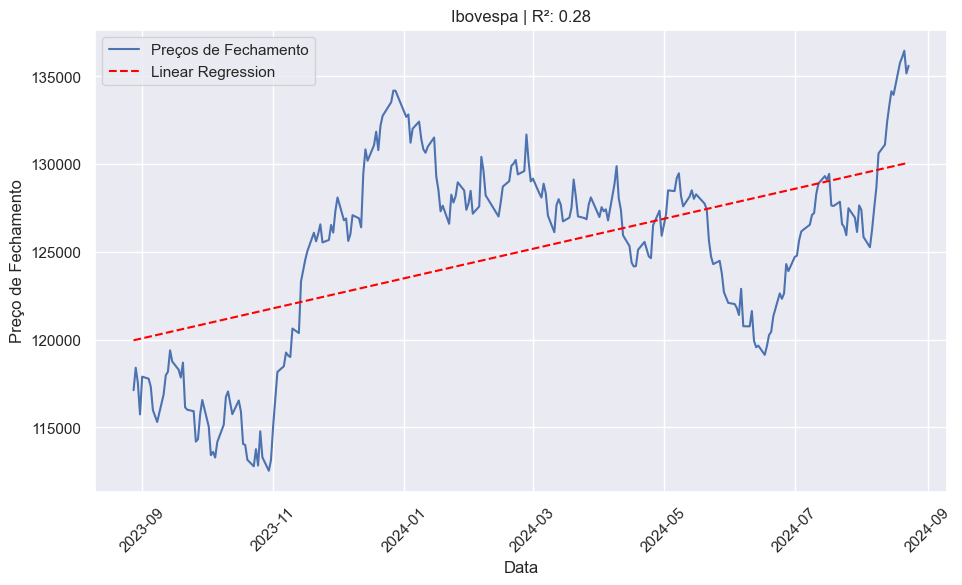

,Métrica,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Lucro,$ 13625.00,$ 7892.27
2,CAGR,27.96%,16.18%
3,Drawdown Max ($),$ -5038.00,$ -5609.79
4,Drawdown Max (%),-8.28%,-9.79%
5,Volatilidade Diária,0.29%,0.83%
6,Volatilidade Anual,4.67%,13.13%
7,Curve Smoothness - R²,0.80,0.28


In [142]:
# Resetar o índice para usar a coluna de datas
df_benchmark.reset_index(inplace=True)  

# Converter a coluna de datas em números para a regressão
df_benchmark['Time_ordinal'] = df_benchmark['Date'].map(pd.Timestamp.toordinal)

# Calcular a regressão linear
slope_benchmark, intercep_benchmark, r_value_benchmark, p_value_benchmark, std_err_benchmark = linregress(df_benchmark['Time_ordinal'], df_benchmark['Close'])

# Calcular o R²
r_squared_benchmark = r_value_benchmark**2

# Adicionar a linha de regressão ao DataFrame
df_benchmark['Regressao'] = intercep_benchmark + slope_benchmark * df_benchmark['Time_ordinal']

# Adicionar métrica ao dataframe
df_metricas.loc[df_metricas['Métrica'] == 'Curve Smoothness - R²', 'Benchmark'] = f'{r_squared_benchmark:.2f}'



plt.figure(figsize=(11, 6))
sns.lineplot(data=df_benchmark, x='Date', y='Close', label='Preços de Fechamento')
sns.lineplot(data=df_benchmark, x='Date', y='Regressao', color='red', linestyle='--', label='Linear Regression')

plt.title(f'Ibovespa | R²: {r_squared_benchmark:.2f}')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.xticks(rotation=45)
plt.legend()
plt.show()
df_metricas

- R²: representa a variabilidade da distribuição de retornos através do modelo de regressão linear, podendo ser interpretado como estabilidade da curva.<br>

#### Calculando métricas de performance do sistema: fator de recuperação, taxa de acerto, payoff, edge, fator de lucro, e expectativa matemática

In [143]:
# Fator de Recuperação
recovery_factor_portfolio = abs(portfolio_profit / max_drawdown_financeiro_portfolio)

# Filtrar operações vencedoras e perdedoras
num_vencedoras = df[df['Profit'] > 0].shape[0]
vencedoras = df[df['Profit'] > 0]['Profit']
perdedoras = df[df['Profit'] < 0]['Profit']
num_total = df.shape[0]

# Calcular a taxa de acerto
taxa_acerto = (num_vencedoras / num_total) * 100 if num_total > 0 else 0

# Calcular a média das operações vencedoras e perdedoras
media_vencedoras = vencedoras.mean()
media_perdedoras = perdedoras.mean()

payoff = media_vencedoras/-media_perdedoras

# Calcular o breakeven
breakeven = (1 / (1+payoff))*100

# Calcular edge
edge = taxa_acerto - breakeven

# Fator de Lucro
soma_lucros = df[df['Profit'] > 0]['Profit'].sum()
soma_perdas = df[df['Profit'] < 0]['Profit'].sum()
fator_lucro = soma_lucros / abs(soma_perdas) if soma_perdas != 0 else np.nan

# Expectativa Matemática
payoff_medio = media_vencedoras / -media_perdedoras
expectancy = (taxa_acerto / 100 * payoff_medio) - ((100 - taxa_acerto) / 100)
expectancy *= 100

# Adicionar ao df de métricas
df_metricas_performance = pd.DataFrame({
    'Métrica': ['Fator Recuperação',
                'Taxa de Acerto', 
                'Payoff', 
                'Edge', 
                'Fator de Lucro',                 
                'Expectativa Matemática',],
    'Portfolio': [f'{recovery_factor_portfolio:.2f}',
              f"{taxa_acerto:.2f}%", 
              f"{payoff:,.2f}", 
              f"{edge:,.2f}%", 
              f"{fator_lucro:.2f}", 
              f"{expectancy:.2f}%"
              ]
})

df_metricas = pd.concat([df_metricas, df_metricas_performance], ignore_index=True)

df_metricas

,Métrica,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Lucro,$ 13625.00,$ 7892.27
2,CAGR,27.96%,16.18%
3,Drawdown Max ($),$ -5038.00,$ -5609.79
4,Drawdown Max (%),-8.28%,-9.79%
5,Volatilidade Diária,0.29%,0.83%
6,Volatilidade Anual,4.67%,13.13%
7,Curve Smoothness - R²,0.80,0.28
8,Fator Recuperação,2.70,NaN
9,Taxa de Acerto,47.92%,NaN


Entendendo as métricas:
- Fator de Recuperação: Razão entre o retorno anual e o drawdown máximo, indicando a capacidade de recuperação após perdas.<br>
- Taxa de Acerto: Percentual de operações bem-sucedidas (lucros) em relação ao total de operações.<br>
- Payoff: Razão entre o lucro médio e a perda média por operação.<br>
- Edge: Indica o potencial lucrativo da estratégia e a sua diferença em relação à taxa de acerto aleatória.<br>
- Fator de Lucro: Razão entre o lucro total e a perda total.<br>
- Expectativa Matemática: Lucro ou perda média esperada por operação considerando o risco médio como referência.<br>



Para calcular indicadores de retorno ajustado ao risco, é necessário obter a taxa livre de risco, que no país do benchmark (Brasil) é representada pela taxa Selic.

#### Calculando a taxa Selic para o período

Valor médio da taxa Selic no período: 11.45%


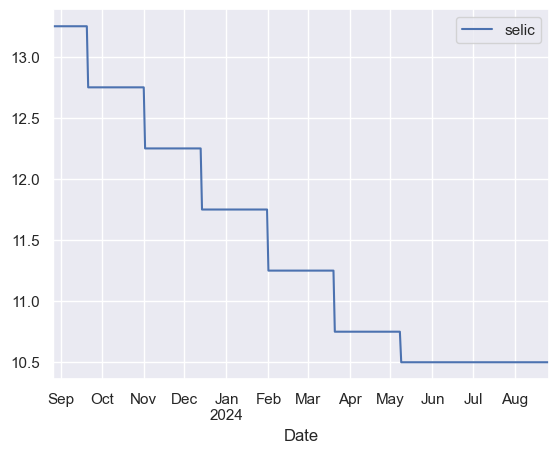

In [144]:
# Obter dados da API do Banco Central
selic = sgs.get({'selic': 432},start = inicio,end = fim)

valor_medio_selic = selic['selic'].mean()
taxa_livre_risco = valor_medio_selic/100

sns.set_theme()
selic.plot()
print(f"Valor médio da taxa Selic no período: {valor_medio_selic:.2f}%")


Interessante notar que há um claro cenário de afrouxamento da política monetária no período.

#### Calculando Sharpe Ratio e VaR

In [145]:
# Sharpe Ratio
retorno_portfolio = (portfolio_profit)/initial_deposit
desvio_padrao = df['Profit'].std() / initial_deposit
sharpe_ratio_portfolio = (retorno_portfolio - taxa_livre_risco) / (volatilidade_anualizada_portfolio/100) if desvio_padrao != 0 else np.nan

# VaR
# Criando e tratando lucros diários do portfolio 
df['daily_profit_portfolio'] = df.groupby('Data')['Profit'].transform('sum')
df_daily_profit_porfolio = df[['Data', 'daily_profit_portfolio']].copy()
df_daily_profit_porfolio = df_daily_profit_porfolio.drop_duplicates(subset='Data',keep='first')
df_daily_profit_porfolio['Portfolio Value'] = initial_deposit + df_daily_profit_porfolio['daily_profit_portfolio'].cumsum()
df_daily_profit_porfolio['Daily Return'] = df_daily_profit_porfolio['Portfolio Value'].pct_change()
df_daily_profit_porfolio = df_daily_profit_porfolio.dropna(subset=['Daily Return'])

# Calcular o VaR
conf_level = 0.95
var_portfolio = df_daily_profit_porfolio['Daily Return'].quantile(1 - conf_level)
var_portfolio *= 100

# Adicionar ao df de métricas
df_metricas_risco = pd.DataFrame({
    'Métrica': ['Sharpe Ratio', 
                #'Calmar Ratio', 
                'VaR (95%)'],
    'Portfolio': [f"{sharpe_ratio_portfolio:.2f}", 
              #f"{calmar_ratio:,.2f}",  
              f"{var_portfolio:.2f}%"]
})

df_metricas = pd.concat([df_metricas, df_metricas_risco], ignore_index=True)

#### Calculando métricas de performance aplicáveis ao benchmark

Nem todas métricas de performance são aplicáveis à comparação com o benchmark. Por exemplo, o payoff representa a média entre operações vencedoras e perdedoras, o que não faz sentido calcular para o benchmark pois está sendo considerado apenas o buy and hold teórico.

In [146]:
# Calcular fator de recuperação do ibov
fr_benchmark = lucro_benchmark / -drawdown_maximo_financeiro_benchmark

# Sharpe Ratio
retorno_benchmark = (lucro_benchmark)/initial_deposit
sharpe_ratio_benchmark = (retorno_benchmark - taxa_livre_risco) / (volatilidade_anualizada_benchmark/100)

#VaR
df_benchmark['Daily Return'] = df_benchmark['Close'].pct_change()
df_benchmark = df_benchmark.dropna(subset=['Daily Return'])

conf_level = 0.95
var_benchmark = df_benchmark['Daily Return'].quantile(1 - conf_level)
var_benchmark *= 100

# Adicionar métricas ao df
df_metricas.loc[df_metricas['Métrica'] == 'Fator Recuperação', 'Benchmark'] = f'{fr_benchmark:.2f}'
df_metricas.loc[df_metricas['Métrica'] == 'Sharpe Ratio', 'Benchmark'] = f'{sharpe_ratio_benchmark:.2f}'
df_metricas.loc[df_metricas['Métrica'] == 'VaR (95%)', 'Benchmark'] = f'{var_benchmark:.2f}%'
df_metricas

,Métrica,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Lucro,$ 13625.00,$ 7892.27
2,CAGR,27.96%,16.18%
3,Drawdown Max ($),$ -5038.00,$ -5609.79
4,Drawdown Max (%),-8.28%,-9.79%
5,Volatilidade Diária,0.29%,0.83%
6,Volatilidade Anual,4.67%,13.13%
7,Curve Smoothness - R²,0.80,0.28
8,Fator Recuperação,2.70,1.41
9,Taxa de Acerto,47.92%,NaN


- Sharpe Ratio: Medida de retorno ajustado pelo risco, calculada como o excesso de retorno do portfólio sobre a taxa livre de risco, dividido pela volatilidade do portfólio.<br>
- VaR (95%): Valor em Risco, indicando a perda máxima esperada com 95% de confiança durante um período específico.<br>

### Avaliando resultados

Vamos plotar novamente os dois gráficos lado a lado para comparação.

Text(0.5, 1.0, 'Ibovespa / R²: 0.28')

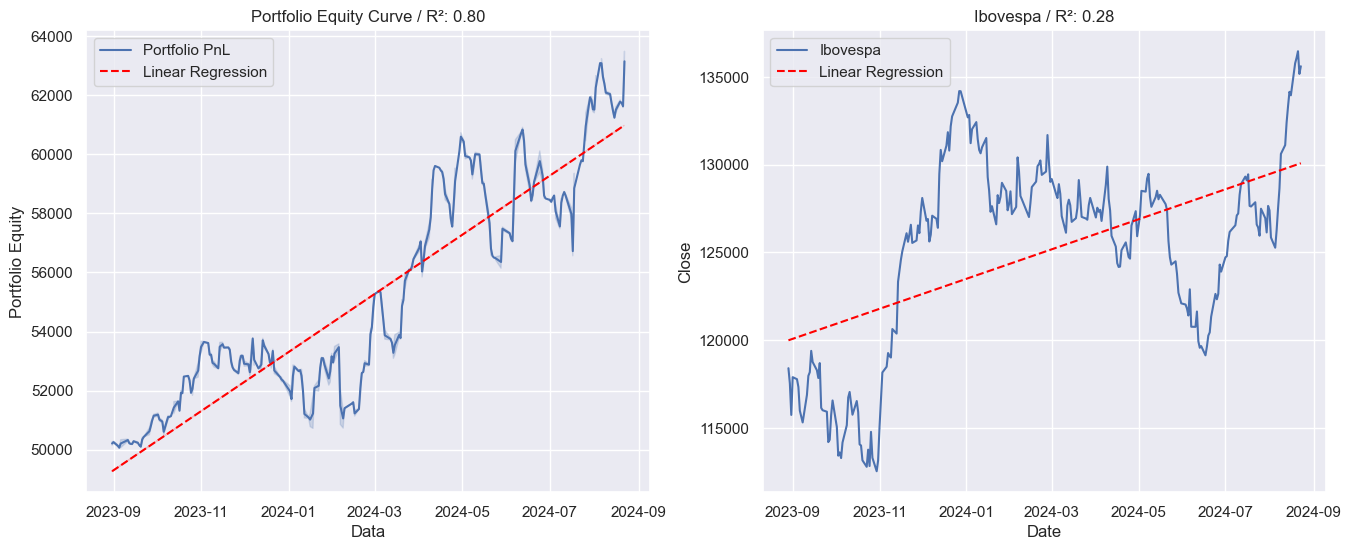

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # 1 linha, 2 colunas

sns.lineplot(data=df, x='Data', y='Portfolio Equity', label='Portfolio PnL',ax=axes[0])
sns.lineplot(data=df, x='Data', y='Regressao', color='red', linestyle='--', label='Linear Regression', ax=axes[0])
axes[0].set_title(f'Portfolio Equity Curve / R²: {r_squared:.2f}')

sns.lineplot(data=df_benchmark, x='Date', y='Close', label='Ibovespa',ax=axes[1])
sns.lineplot(data=df_benchmark, x='Date', y='Regressao', color='red', linestyle='--', label='Linear Regression', ax=axes[1])
axes[1].set_title(f'Ibovespa / R²: {r_squared_benchmark:.2f}')

In [148]:
df_metricas.fillna("N/A")

,Métrica,Portfolio,Benchmark
0,Deposit,$ 50000.00,$ 50000.00
1,Lucro,$ 13625.00,$ 7892.27
2,CAGR,27.96%,16.18%
3,Drawdown Max ($),$ -5038.00,$ -5609.79
4,Drawdown Max (%),-8.28%,-9.79%
5,Volatilidade Diária,0.29%,0.83%
6,Volatilidade Anual,4.67%,13.13%
7,Curve Smoothness - R²,0.80,0.28
8,Fator Recuperação,2.70,1.41
9,Taxa de Acerto,47.92%,N/A


Vamos analisar as métricas. Valores com N/A para o benchmark são métricas que não são aplicáveis para sistemas com apenas uma operação (buy and hold).


##### Portfolio vs. Benchmark

O portfólio apresentou uma performance superior em relação ao Ibovespa em praticamente todas as métricas avaliadas. Com uma rentabilidade de 27,96% contra 16,18% do Ibovespa, e um drawdown de -8,28% em comparação com -9,79% do índice, o portfólio entregou retornos muito superiores mantendo um drawdown relativamente similar. A volatilidade anualizada foi significativamente menor, 4,67% contra 13,13% do Ibovespa, destacando a maior estabilidade e consistência do portfólio ao longo do período.

Além disso, o portfólio obteve um Sharpe Ratio notavelmente alto de 3,36, muito superior ao 0,33 do Ibovespa, indicando uma excelente relação entre risco e retorno. O coeficiente de determinação (R²) de 0,80, em contraste com os 0,28 do benchmark, evidencia a estabilidade superior dos retornos e a consistência da curva de desempenho do portfólio, refletindo sua eficácia em capturar alfa no mercado com menor volatilidade nos retornos. A maior estabilidade também pode ser observada visualmente nos gráficos.

No entanto, o VaR apresentou uma leve desvantagem, com o portfólio registrando -1,40% em comparação com -1,26% do Ibovespa. Esse resultado sugere uma maior exposição a eventos negativos. Vamos analisar o gráfico de distribuição de trades do portfolio.

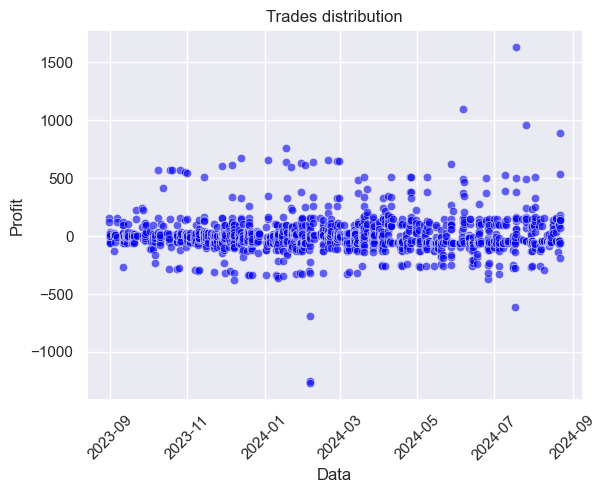

In [153]:
sns.scatterplot(data=df, x='Data', y='Profit', color='blue', alpha=0.6)
plt.title('Trades distribution')
plt.ylabel('Profit')
plt.xticks(rotation=45)

 Observa-se uma distribuição uniforme ao longo da maior parte do período analisado. Embora os outliers vencedores aparentem ser maiores do que os perdedores, as perdas significativas impactaram negativamente o VaR, pois é um indicador que avalia o risco de maneira mais rigorosa. Apesar da diferença entre o VaR do portfólio e o do benchmark ser pequena, seria interessante um aprofundamento na análise e aprimoramento dos algoritmos para tentar mitigar o impacto de eventos extremos e melhorar o controle sobre o risco máximo potencial do portfólio.
 


### Hipótese de alocação de investimentos


Para fins de comparação de performance, o benchmark utilizado foi o buy and hold de todo o valor depositado. No entanto, essa abordagem não considera a possibilidade de alocar o capital em diferentes investimentos. 

No caso deste portfólio, que opera exclusivamente no intraday, a margem operacional necessária é significativamente menor. Portanto, é possível utilizar uma alocação de margem reduzida em comparação ao montante total investido. 

Por exemplo, alocando apenas 30% do capital como margem (equivalente a R$ 15.000, ou 3 vezes o drawdown máximo observado), é viável investir os 70% restantes em renda fixa livre de risco. Essa estratégia não apenas mantém a operação intraday eficiente com uma alocação de margem otimizada, mas também proporciona uma rentabilidade adicional com a alocação em produtos de menor risco, tornando a rentabilidade global do investimento ainda mais atraente.<br>
 
Vamos calcular o rendimento da renda fixa no período e avaliar esse cenário.

##### Calculando rendimento da renda fixa <br>
Considerando a hipótese de alocação de 70% do capital em renda fixa, vamos calcular sua rentabilidade média no período.

In [149]:
fixedincome_alocated_capital = initial_deposit * 0.70
fixedincome_yield = fixedincome_alocated_capital * valor_medio_selic/100
profit_total = portfolio_profit + fixedincome_yield

valor_final_total = initial_deposit + profit_total
num_anos = (df['Time'].max() - df['Time'].min()).days / 365.25
cagr_total = (valor_final_total / initial_deposit) ** (1 / num_anos) - 1
cagr_total *= 100

df['FixedIncomeYield'] = fixedincome_yield * (df['Time'] - df['Time'].min()).dt.days / 365.25
df['Total Equity'] = df['Portfolio Equity'] + df['FixedIncomeYield']
print(f"Lucro da Renda Fixa no período: $ {fixedincome_yield:.2f}")

Lucro da Renda Fixa no período: $ 4008.55


Plotando a curva de capital final e valores

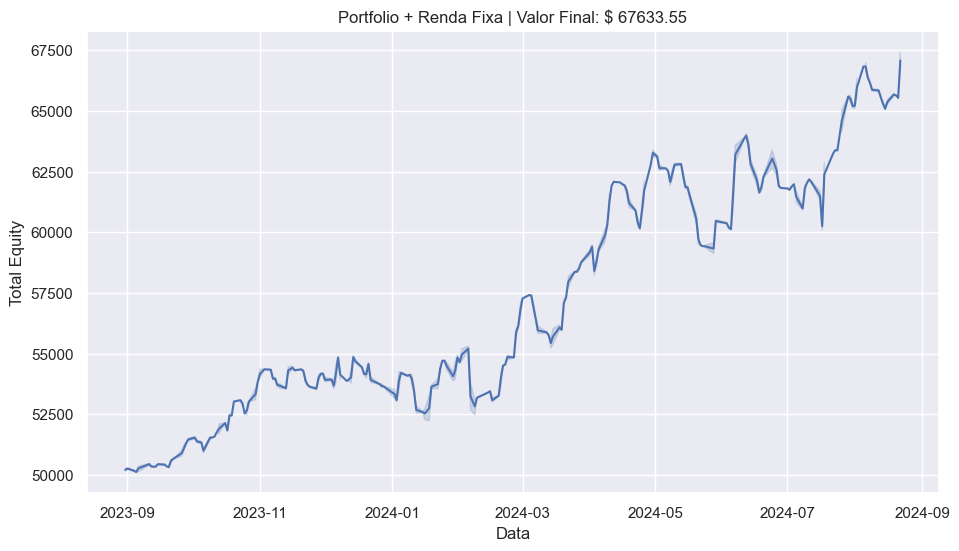

Lucro do Portfolio: $ 13625.00
Lucro da Renda Fixa: $ 4008.55
Lucro Total (Portfólio + Risk Free Return): $ 17633.55
Valor Final Total (Portfólio + Renda Fixa): $ 67633.55
CAGR Total (Portfólio + Renda Fixa): 36.21%


In [150]:
plt.figure(figsize=(11, 6))
sns.lineplot(data=df, x='Data', y='Total Equity')
plt.title(f'Portfolio + Renda Fixa | Valor Final: $ {valor_final_total:.2f}')
plt.xlabel('Data')
plt.ylabel('Total Equity')
plt.show()

# Exibe os valores calculados
print(f"Lucro do Portfolio: $ {portfolio_profit:.2f}")
print(f"Lucro da Renda Fixa: $ {fixedincome_yield:.2f}")
print(f"Lucro Total (Portfólio + Risk Free Return): $ {profit_total:.2f}")
print(f"Valor Final Total (Portfólio + Renda Fixa): $ {valor_final_total:.2f}")
print(f"CAGR Total (Portfólio + Renda Fixa): {cagr_total:.2f}%")

Ao adotar uma alocação de 30% do capital para o portfólio e 70% para a renda fixa, o investidor obteria um valor adicional de R$ 4008.55. Isso resultaria em um montante total de R$ 17.633.55, representando um retorno anualizado total de 36,21%, mantendo o mesmo drawdown máximo de 8,28%. Essa alocação aumenta ainda mais a atratividade do investimento.<br>



### Considerações finais


Mesmo diante de um cenário de afrouxamento da política monetária e com o Ibovespa valorizando cerca de 16% no período, esta análise exploratória revelou que, ao incluir o portfólio de algoritmos em sua carteira o investidor obteve um retorno substancialmente superior ao benchmark. As duas alocações de capital analisadas – aplicando todo o investimento no portfólio ou separando parte para a renda fixa - apresentaram resultados superiores e significativos. 


A utilização do portfólio permitiu uma distribuição mais eficiente dos retornos, resultando em métricas de desempenho robustas e indicadores de retorno ajustado ao risco bastante satisfatórios. Considerando uma taxa livre de risco média de 11,45% no período, o Sharpe Ratio de 3.38 destaca-se de forma notável. 

Este estudo oferece uma visão valiosa para investidores sobre a integração de algoritmos e automação em suas estratégias de investimento, evidenciando a importância de uma alocação de capital bem planejada e diversificada para maximizar retornos e gerenciar riscos de forma eficiente.